# Graph Neural Network

In [1]:
import pandas as pd
import numpy as np
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, OWL, XSD
import os

from torch_geometric.data import Data
import torch
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from rdflib.namespace import XSD
from sklearn.preprocessing import StandardScaler
import random
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\mahmoud uni\\TU\\SS2024\\KGs\\Portfolio'

## Load Knowledge Graph

In [3]:
# # Load the ontology
BASE = Namespace("http://www.semanticweb.org/mabsa/ontologies/2024/10/ea-fc-ontology/")
g = Graph()
ontology_file = r"dataset\EA_FC_knowledge_graph.ttl" 
g.parse(ontology_file, format="ttl")

<Graph identifier=N352dda84616c43d8927a1531f129e651 (<class 'rdflib.graph.Graph'>)>

In [4]:
# Count all triples
print(f"Total triples: {len(g)}")

# Check for specific class membership
player_count = len(list(g.subjects(RDF.type, BASE.Player)))
print(f"Total Players: {player_count}")

team_count = len(list(g.subjects(RDF.type, BASE.Club)))
print(f"Total Teams: {team_count}")

league_count = len(list(g.subjects(RDF.type, BASE.League)))
print(f"Total Leagues: {league_count}")

Total triples: 214730
Total Players: 3504
Total Teams: 1664
Total Leagues: 174


## Data Preperation

### Node Extraction

In [5]:
# extract nodes
players = list(g.subjects(RDF.type, BASE.Player))
clubs = list(g.subjects(RDF.type, BASE.Club))
leagues = list(g.subjects(RDF.type, BASE.League))

# mapping for node indices
node_list = players + clubs + leagues
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

In [6]:
# Label Encoders for Categorical Features
position_encoder = LabelEncoder()
foot_encoder = LabelEncoder()
work_rate_encoder = LabelEncoder()
body_type_encoder = LabelEncoder()
league_encoder = LabelEncoder()
nationality_encoder = LabelEncoder()

# Collect all unique categories for encoding
positions = set()
preferred_feet = set()
work_rate_components = set()
body_types = set()
league_names = set()
nationalities = set()

# Collect categories for players
for player in players:
    for p, o in g.predicate_objects(player):
        if p == BASE.position_category:
            positions.add(str(o))
        if p == BASE.preferred_foot:
            preferred_feet.add(str(o))
        if p == BASE.work_rate:
            work_rate = str(o)
            work_rate_att, work_rate_def = work_rate.split('/')
            work_rate_components.add(work_rate_att)
            work_rate_components.add(work_rate_def)
        if p == BASE.body_type:
            body_types.add(str(o))

# Collect categories for clubs and leagues
for club in clubs:
    for p, o in g.predicate_objects(club):
        if p == BASE.name:
            league_names.add(str(o))

for league in leagues:
    for p, o in g.predicate_objects(league):
        if p == BASE.league_nationality_name:
            nationalities.add(str(o))

# Fit Encoders
position_encoder.fit(list(positions))
foot_encoder.fit(list(preferred_feet))
work_rate_encoder.fit(list(work_rate_components))  # Now fitted on individual components
body_type_encoder.fit(list(body_types))
league_encoder.fit(list(league_names))
nationality_encoder.fit(list(nationalities))


LabelEncoder()

### Feature Extraction

In [7]:
features = []
targets = []

for node in node_list:
    attrs = {}
    for p, o in g.predicate_objects(node):
        # Handle Numeric Features
        if isinstance(o, Literal):
            if o.datatype in [XSD.integer, XSD.float, XSD.double]:  # Numeric DataTypes
                attrs[p.split("/")[-1]] = float(o)
            elif o.datatype in [XSD.string, None]:  # Categorical/String
                key = p.split("/")[-1]
                if key != 'name':  # Exclude player name from features
                    attrs[key] = str(o)

    # Encode Categorical Features
    position_encoded = position_encoder.transform([attrs.get('position_category', 'DEF')])[0] if 'position_category' in attrs else 0
    preferred_foot_encoded = foot_encoder.transform([attrs.get('preferred_foot', 'Right')])[0] if 'preferred_foot' in attrs else 0
    body_type_encoded = body_type_encoder.transform([attrs.get('body_type', 'Normal')])[0] if 'body_type' in attrs else 0
    league_encoded = league_encoder.transform([attrs.get('name', 'Unknown')])[0] if 'name' in attrs else 0
    nationality_encoded = nationality_encoder.transform([attrs.get('league_nationality_name', 'Unknown')])[0] if 'league_nationality_name' in attrs else 0

    # Handle work_rate
    work_rate_att, work_rate_def = attrs.get('work_rate', 'Medium/Medium').split('/') if 'work_rate' in attrs else ('Medium', 'Medium')
    work_rate_att_encoded = work_rate_encoder.transform([work_rate_att])[0]
    work_rate_def_encoded = work_rate_encoder.transform([work_rate_def])[0]

    # Numeric Features
    numeric_features = [v for k, v in attrs.items() if isinstance(v, float) and k != 'name' and k != 'player_id'] 

    # Combine Features
    feature_vector = numeric_features + [
        position_encoded, 
        preferred_foot_encoded, 
        work_rate_att_encoded, 
        work_rate_def_encoded, 
        body_type_encoded,
        league_encoded,
        nationality_encoded
    ]

    # Correctly Extract 'potential'
    potential = attrs.get('potential', None)

    features.append(feature_vector)
    targets.append(potential if potential is not None else 0)

# Padding feature vectors to have the same length
max_len = max(len(f) for f in features)
features = [f + [0] * (max_len - len(f)) for f in features]

In [8]:
# # Debugging: Inspect sample player data
# sample = leagues[0]
# for p, o in g.predicate_objects(sample):
#     print(f"Predicate: {p}, Object: {o}, Data Type: {type(o)}, RDF DataType: {getattr(o, 'datatype', None)}")

### Edge Index

In [9]:
edge_index = []

for s, p, o in g:
    if s in node_to_idx and o in node_to_idx:
        edge_index.append([node_to_idx[s], node_to_idx[o]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

### Train-Test-Val Split

#### Random Split

In [11]:
# Set seed for reproducibility
seed = 1120
np.random.seed(seed)
torch.manual_seed(seed)

# Get the total number of nodes
num_nodes = len(node_list)

# Shuffle all node indices randomly
indices = np.random.permutation(num_nodes)

# Define split sizes
train_cutoff_rand = int(0.6 * num_nodes)
val_cutoff_rand = int(0.8 * num_nodes)

# Assign indices to train, validation, and test sets
train_indices_rand = indices[:train_cutoff_rand]
val_indices_rand = indices[train_cutoff_rand:val_cutoff_rand]
test_indices_rand = indices[val_cutoff_rand:]

# Create masks
train_mask_rand = torch.zeros(num_nodes, dtype=torch.bool)
val_mask_rand = torch.zeros(num_nodes, dtype=torch.bool)
test_mask_rand = torch.zeros(num_nodes, dtype=torch.bool)

train_mask_rand[train_indices_rand] = True
val_mask_rand[val_indices_rand] = True
test_mask_rand[test_indices_rand] = True

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(targets, dtype=torch.float)

# Create new PyG Data object for the random split
data_rand = Data(x=x, edge_index=edge_index, y=y, 
                 train_mask=train_mask_rand, 
                 val_mask=val_mask_rand, 
                 test_mask=test_mask_rand)

# Standardize the features
data_rand.x = torch.tensor(StandardScaler().fit_transform(data_rand.x), dtype=torch.float)

# Display the new data object
data_rand

Data(x=[5342, 52], edge_index=[2, 9924], y=[5342], train_mask=[5342], val_mask=[5342], test_mask=[5342])

#### Stratfied Split

In [12]:
seed = 1120
np.random.seed(seed)
torch.manual_seed(seed)

# Step 1: Extract unique player IDs
unique_player_ids = set()
player_id_to_indices = {}

for idx, node in enumerate(players):
    for p, o in g.predicate_objects(node):
        if p == BASE.player_id:
            player_id_full = str(o)
            player_unique_id = player_id_full.split('_')[0]
            unique_player_ids.add(player_unique_id)

            # Map unique player ID to indices in node_list
            if player_unique_id not in player_id_to_indices:
                player_id_to_indices[player_unique_id] = []
            player_id_to_indices[player_unique_id].append(idx)

# Step 2: Shuffle and split player IDs
unique_player_ids = list(unique_player_ids)
np.random.shuffle(unique_player_ids)

num_players = len(unique_player_ids)
train_cutoff = int(0.6 * num_players)
val_cutoff = int(0.8 * num_players)

train_ids = unique_player_ids[:train_cutoff]
val_ids = unique_player_ids[train_cutoff:val_cutoff]
test_ids = unique_player_ids[val_cutoff:]

# Step 3: Create masks
train_mask = torch.zeros(len(node_list), dtype=torch.bool)
val_mask = torch.zeros(len(node_list), dtype=torch.bool)
test_mask = torch.zeros(len(node_list), dtype=torch.bool)  

for player_id in train_ids:
    for idx in player_id_to_indices[player_id]:
        train_mask[idx] = True

for player_id in val_ids:
    for idx in player_id_to_indices[player_id]:
        val_mask[idx] = True

for player_id in test_ids:
    for idx in player_id_to_indices[player_id]:
        test_mask[idx] = True

# Step 4: Create PyG Data Object
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(targets, dtype=torch.float)

# Ensure edge_index is already defined as in the previous code
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.x = torch.tensor(StandardScaler().fit_transform(data.x), dtype=torch.float)

# Display the graph data
print(data)

Data(x=[5342, 52], edge_index=[2, 9924], y=[5342], train_mask=[5342], val_mask=[5342], test_mask=[5342])


In [13]:
print(f"Total nodes: {data.num_nodes}")
print(f"Player nodes: {len(players)}, Club nodes: {len(clubs)}, League nodes: {len(leagues)}")

Total nodes: 5342
Player nodes: 3504, Club nodes: 1664, League nodes: 174


In [14]:
def validate_split():
    train_players = set(train_ids)
    val_players = set(val_ids)
    test_players = set(test_ids)

    overlap_train_val = train_players.intersection(val_players)
    overlap_train_test = train_players.intersection(test_players)
    overlap_val_test = val_players.intersection(test_players)

    print("Validation Results:")
    print(f"Overlap between Train and Validation: {len(overlap_train_val)}")
    print(f"Overlap between Train and Test: {len(overlap_train_test)}")
    print(f"Overlap between Validation and Test: {len(overlap_val_test)}")

    assert len(overlap_train_val) == 0, "Overlap detected between Train and Validation sets!"
    assert len(overlap_train_test) == 0, "Overlap detected between Train and Test sets!"
    assert len(overlap_val_test) == 0, "Overlap detected between Validation and Test sets!"

    # Proportion Calculation
    total_players = len(train_players) + len(val_players) + len(test_players)
    print("\nProportion of each split:")
    print(f"Train Set: {len(train_players)} players ({(len(train_players)/total_players)*100:.2f}%)")
    print(f"Validation Set: {len(val_players)} players ({(len(val_players)/total_players)*100:.2f}%)")
    print(f"Test Set: {len(test_players)} players ({(len(test_players)/total_players)*100:.2f}%)")

    print("\nNo overlaps detected. The split is valid.")

# Run validation
validate_split()

Validation Results:
Overlap between Train and Validation: 0
Overlap between Train and Test: 0
Overlap between Validation and Test: 0

Proportion of each split:
Train Set: 525 players (59.93%)
Validation Set: 175 players (19.98%)
Test Set: 176 players (20.09%)

No overlaps detected. The split is valid.


## Model Preperation

In [15]:
def set_seed(seed=1120):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Step 1: Define GNN Model
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GNN, self).__init__()
        
        # Graph Convolution Layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        #self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

        # Fully Connected Layer for Regression
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Graph Convolution Layers with ReLU Activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Final Output Layer
        out = self.fc(x)
        return out.squeeze()  # Squeeze to match the shape of target (y)

# Step 2: Training Function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss.item()

# Step 3: Evaluation Function (Handles Both Validation & Test)
def evaluate(model, data, criterion, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[mask], data.y[mask])

        # Calculate MAE, RMSE, and R^2 Score
        mae = F.l1_loss(out[mask], data.y[mask]).item()
        rmse = torch.sqrt(F.mse_loss(out[mask], data.y[mask])).item()
        ss_res = torch.sum((data.y[mask] - out[mask]) ** 2)
        ss_tot = torch.sum((data.y[mask] - torch.mean(data.y[mask])) ** 2)
        r2 = 1 - ss_res / ss_tot

    return loss.item(), mae, rmse, r2.item()



## Random Split Model Implementation

In [16]:
# Set up input dimensions and model
input_dim_rand = data_rand.x.shape[1]  # Number of features per node
hidden_dim_rand = 32  # Hidden dimension size

set_seed(1120)
model_rand = GNN(input_dim_rand, hidden_dim_rand)
optimizer_rand = torch.optim.Adam(model_rand.parameters(), lr=0.001, weight_decay=1e-3)
scheduler_rand = StepLR(optimizer_rand, step_size=1000, gamma=0.8)  # Learning rate decay
criterion_rand = nn.MSELoss()

# Training loop
num_epochs_rand = 10000
best_val_loss_rand = float("inf")  # Track best validation loss
best_model_rand = None  # Store best model state
patience_rand = 500  # Early stopping patience
counter_rand = 0  # Track number of epochs since last improvement

for epoch in range(1, num_epochs_rand + 1):
    train_loss_rand = train(model_rand, data_rand, optimizer_rand, criterion_rand)
    scheduler_rand.step()  # Apply learning rate scheduling
    val_loss_rand, val_mae_rand, val_rmse_rand, val_r2_rand = evaluate(model_rand, data_rand, criterion_rand, data_rand.val_mask)  # Use validation set

    # Save best model based on validation loss
    if val_loss_rand < best_val_loss_rand:
        best_val_loss_rand = val_loss_rand
        best_model_rand = model_rand.state_dict()
        counter_rand = 0  # Reset early stopping counter
    else:
        counter_rand += 1

    # Check early stopping condition
    if counter_rand >= patience_rand:
        print(f"Early stopping triggered at epoch {epoch}")
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss_rand:.4f} | Val Loss: {val_loss_rand:.4f} | Val MAE: {val_mae_rand:.4f} | Val RMSE: {val_rmse_rand:.4f} | Val R^2: {val_r2_rand:.4f}")
        break

    if epoch % 500 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss_rand:.4f} | Val Loss: {val_loss_rand:.4f} | Val MAE: {val_mae_rand:.4f} | Val RMSE: {val_rmse_rand:.4f} | Val R^2: {val_r2_rand:.4f}")


Epoch 500 | Train Loss: 547.2991 | Val Loss: 632.8298 | Val MAE: 15.6255 | Val RMSE: 25.1561 | Val R^2: 0.5064
Epoch 1000 | Train Loss: 169.1249 | Val Loss: 266.5373 | Val MAE: 8.1410 | Val RMSE: 16.3260 | Val R^2: 0.7921
Epoch 1500 | Train Loss: 84.0551 | Val Loss: 183.7782 | Val MAE: 5.8103 | Val RMSE: 13.5565 | Val R^2: 0.8567
Epoch 2000 | Train Loss: 49.6580 | Val Loss: 147.4084 | Val MAE: 4.7250 | Val RMSE: 12.1412 | Val R^2: 0.8850
Epoch 2500 | Train Loss: 32.9416 | Val Loss: 132.5622 | Val MAE: 3.9647 | Val RMSE: 11.5136 | Val R^2: 0.8966
Epoch 3000 | Train Loss: 23.0713 | Val Loss: 115.6749 | Val MAE: 3.7692 | Val RMSE: 10.7552 | Val R^2: 0.9098
Epoch 3500 | Train Loss: 16.6863 | Val Loss: 104.5699 | Val MAE: 3.0653 | Val RMSE: 10.2259 | Val R^2: 0.9184
Epoch 4000 | Train Loss: 13.4668 | Val Loss: 96.6714 | Val MAE: 2.7836 | Val RMSE: 9.8322 | Val R^2: 0.9246
Epoch 4500 | Train Loss: 11.1052 | Val Loss: 94.3711 | Val MAE: 2.6613 | Val RMSE: 9.7145 | Val R^2: 0.9264
Epoch 5000 |

In [17]:
# Define the file path to save the model
model_path_rand = "models/best_model_rand.pth"
torch.save(best_model_rand, model_path_rand)
 
print(f"Model saved successfully at {model_path_rand}")

Model saved successfully at models/best_model_rand.pth


In [18]:
# Load best model before evaluating on test set
model_rand.load_state_dict(best_model_rand)

# Final Test Evaluation
test_loss_rand, test_mae_rand, test_rmse_rand, test_r2_rand = evaluate(model_rand, data_rand, criterion_rand, data_rand.test_mask)
print(f"\nFinal Test Evaluation - Loss: {test_loss_rand:.4f} | MAE: {test_mae_rand:.4f} | RMSE: {test_rmse_rand:.4f} | R^2: {test_r2_rand:.4f}")


Final Test Evaluation - Loss: 93.3469 | MAE: 2.3900 | RMSE: 9.6616 | R^2: 0.9262


## Stratfied Split Model Implementation

In [19]:
# Step 4: Model Training Loop
input_dim = data.x.shape[1]  # Number of features per node
#hidden_dim = 64              # Hidden dimension size
hidden_dim = 32              # Hidden dimension size

set_seed(1120)
model = GNN(input_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)  # Learning rate decay
criterion = nn.MSELoss()

# Training Loop
num_epochs = 10000
best_val_loss = float("inf")  # Track best validation loss
best_model = None  # Store best model state
patience = 500  # Early stopping patience
counter = 0  # Track number of epochs since last improvement

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, data, optimizer, criterion)
    scheduler.step()  # Apply learning rate scheduling
    val_loss, val_mae, val_rmse, val_r2 = evaluate(model, data, criterion, data.val_mask)  # Use validation set

    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        counter = 0  # Reset early stopping counter
    else:
        counter += 1
    
    # Check early stopping condition
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}")
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f} | Val R^2: {val_r2:.4f}")
        break

    if epoch % 500 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f} | Val R^2: {val_r2:.4f}")


Epoch 500 | Train Loss: 9.5267 | Val Loss: 11.1532 | Val MAE: 2.6371 | Val RMSE: 3.3396 | Val R^2: 0.8204
Epoch 1000 | Train Loss: 2.0005 | Val Loss: 2.5184 | Val MAE: 1.2492 | Val RMSE: 1.5870 | Val R^2: 0.9594
Epoch 1500 | Train Loss: 0.8541 | Val Loss: 0.9995 | Val MAE: 0.7874 | Val RMSE: 0.9997 | Val R^2: 0.9839
Epoch 2000 | Train Loss: 0.4033 | Val Loss: 0.4493 | Val MAE: 0.5228 | Val RMSE: 0.6703 | Val R^2: 0.9928
Epoch 2500 | Train Loss: 0.2587 | Val Loss: 0.2895 | Val MAE: 0.4150 | Val RMSE: 0.5381 | Val R^2: 0.9953
Epoch 3000 | Train Loss: 0.1593 | Val Loss: 0.1848 | Val MAE: 0.3264 | Val RMSE: 0.4299 | Val R^2: 0.9970
Epoch 3500 | Train Loss: 0.0732 | Val Loss: 0.1090 | Val MAE: 0.2480 | Val RMSE: 0.3302 | Val R^2: 0.9982
Epoch 4000 | Train Loss: 0.0432 | Val Loss: 0.0696 | Val MAE: 0.1944 | Val RMSE: 0.2638 | Val R^2: 0.9989
Epoch 4500 | Train Loss: 0.0306 | Val Loss: 0.0494 | Val MAE: 0.1623 | Val RMSE: 0.2223 | Val R^2: 0.9992
Epoch 5000 | Train Loss: 0.0216 | Val Loss: 0.

In [20]:
# Define the file path to save the model
model_path = "models/best_model.pth"
torch.save(best_model, model_path)

print(f"Model saved successfully at {model_path}")

Model saved successfully at models/best_model.pth


In [21]:
# Load best model before evaluating on test set
model.load_state_dict(best_model)

# Final Test Evaluation
test_loss, test_mae, test_rmse, test_r2 = evaluate(model, data, criterion, data.test_mask)
print(f"\nFinal Test Evaluation - Loss: {test_loss:.4f} | MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f} | R^2: {test_r2:.4f}")


Final Test Evaluation - Loss: 0.0074 | MAE: 0.0660 | RMSE: 0.0861 | R^2: 0.9999


## Evaluation

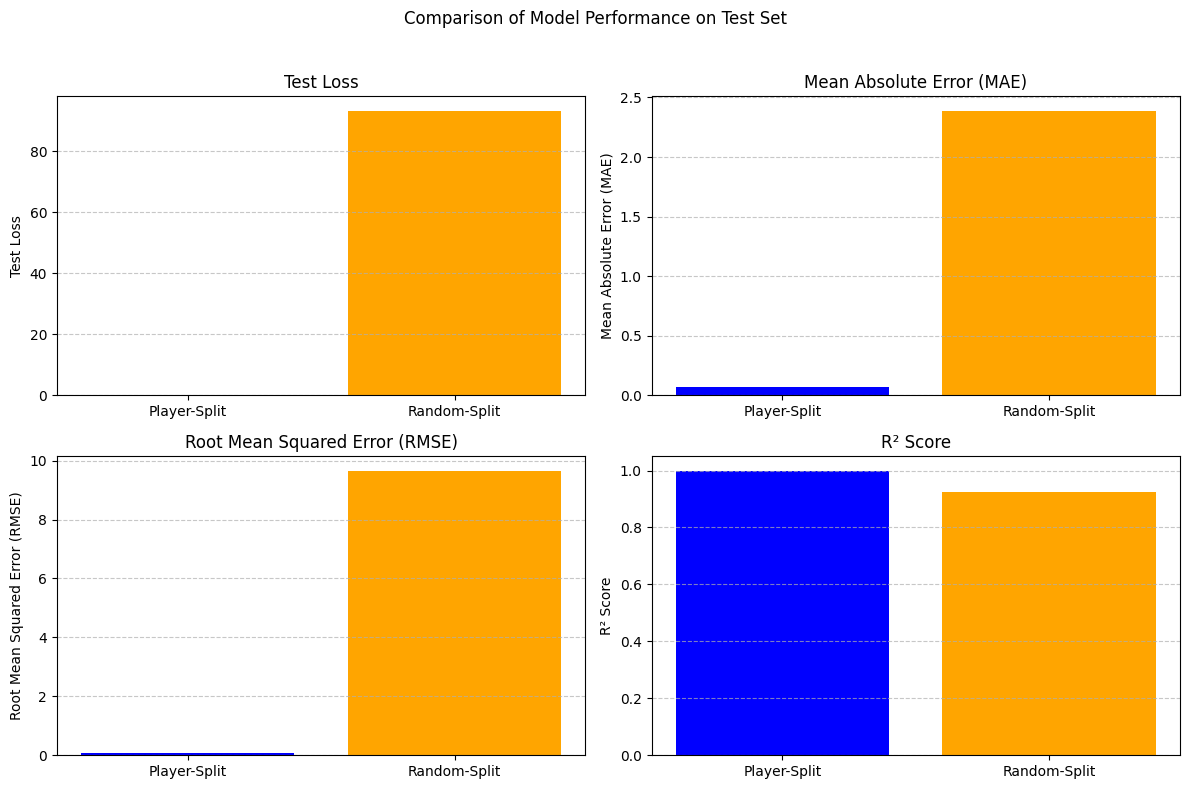

In [23]:
# Evaluate both models on their respective test sets
test_loss, test_mae, test_rmse, test_r2 = evaluate(model, data, criterion, data.test_mask)
test_loss_rand, test_mae_rand, test_rmse_rand, test_r2_rand = evaluate(model_rand, data_rand, criterion, data_rand.test_mask)

# Store results in a dictionary
metrics = {
    "Test Loss": [test_loss, test_loss_rand],
    "Mean Absolute Error (MAE)": [test_mae, test_mae_rand],
    "Root Mean Squared Error (RMSE)": [test_rmse, test_rmse_rand],
    "R² Score": [test_r2, test_r2_rand]
}

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Comparison of Model Performance on Test Set")

# Iterate through metrics and plot
for ax, (metric_name, values) in zip(axes.flat, metrics.items()):
    ax.bar(["Player-Split", "Random-Split"], values, color=["blue", "orange"])
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()